## Data Wrangling

In [44]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0
from tqdm import tqdm

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

In [71]:
df = pd.read_csv("G:/Shared drives/common/personal-folders-team/Ujjwal-Dhiman/data-training/route-optimization-challenge/50_sampled.csv")
df['id'] = range(50)
col_order = ['id','y','x','amenity','name']
df = df.reindex(columns=col_order)
df.head()

id         y           x amenity                    name
0   0  1.301344  103.875762    taxi    Little India Station
1   1  1.298414  103.850258    taxi  Tanjong Katong Complex
2   2  1.333340  103.740644    taxi      Paya Lebar Station
3   3  1.280234  103.848762    taxi        Aljunied Station
4   4  1.299981  103.822485    taxi                  Blk 19

In [72]:
# pinpoint your starting location
i = 0
df["base"] = df["id"].apply(lambda x: 1 if x==i else 0)
start = df[df["base"]==1][["y","x"]].values[0]

print("start =", start)
df.head(3)

start = [  1.301344 103.875762]


id         y           x amenity                    name  base
0   0  1.301344  103.875762    taxi    Little India Station     1
1   1  1.298414  103.850258    taxi  Tanjong Katong Complex     0
2   2  1.333340  103.740644    taxi      Paya Lebar Station     0

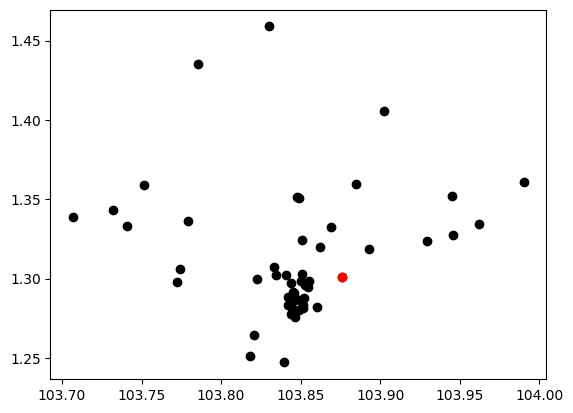

In [73]:
plt.scatter(y=df["y"], x=df["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [46]:
def plot_map(df, y, x, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = df.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(df[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)
    
    ## tiles
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(map_)
    folium.LayerControl(position='bottomright').add_to(map_)
    
    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))
    
    ## add marker
    if marker is not None:
        lst_elements = sorted(list(df[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1) 
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)
    
    ## full screen
    plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(map_)
    return map_

In [50]:
map_ = plot_map(df, y="y", x="x", start=start, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black", "red"])
map_

In [51]:
# we need to find the most convenient way for the red point (depot) to serve all the other locations (customers).

# add lines
for i in range(len(df)):
    points = [start, df[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, color="red", weight=0.5, opacity=0.5).add_to(map_)
map_ 

## 1 - Shortest Path (between 2 locations)

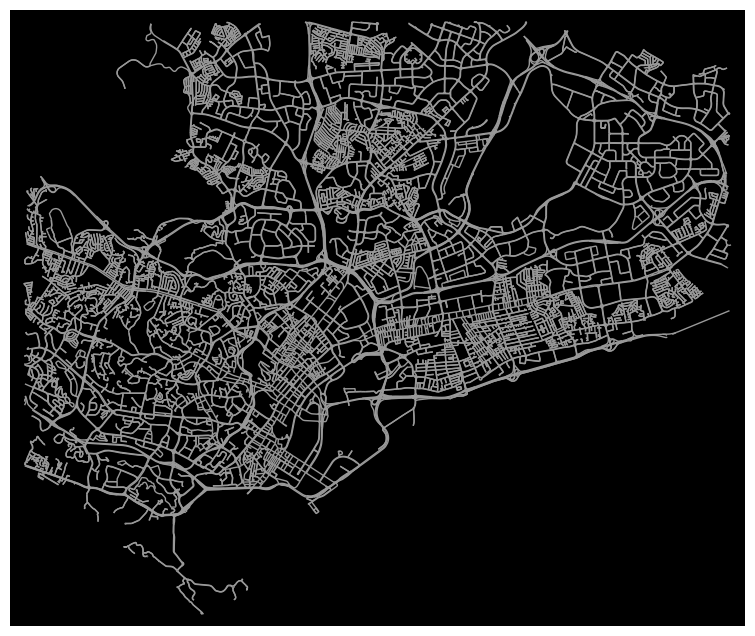

In [7]:
# we are considering the road network as a graph and find the shortest path between nodes.

# create network graph
G = ox.graph_from_point(start, dist=10000, 
        network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# plot
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=0, node_color="white", figsize=(16,8))

In [8]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 14019


osmid         y           x  street_count  ref            highway   
0  25451929  1.295232  103.872544             3  NaN                NaN  \
1  25455287  1.295445  103.874004             3  14A  motorway_junction   
2  25455292  1.301013  103.908497             3  10B  motorway_junction   

                    geometry  
0  POINT (103.87254 1.29523)  
1  POINT (103.87400 1.29544)  
2  POINT (103.90850 1.30101)

In [9]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 27075


u           v  key   
0  25451929  6749812859    0  \
1  25455287  1637003462    0   
2  25455287  2521018789    0   

                                               osmid  oneway   lanes  ref   
0  [49961799, 718881456, 741164883, 754786742, 17...    True       5  ECP  \
1                                          150829205    True       1  NaN   
2                   [633215386, 74607482, 635109319]    True  [2, 3]  ECP   

                 name        highway maxspeed reversed   length bridge   
0  East Coast Parkway       motorway       70    False  765.032    yes  \
1                 NaN  motorway_link       50    False  629.055    NaN   
2  East Coast Parkway       motorway       90    False  652.576    NaN   

                                            geometry  speed_kph  travel_time   
0  LINESTRING (103.87254 1.29523, 103.87103 1.295...       70.0         39.3  \
1  LINESTRING (103.87400 1.29544, 103.87413 1.295...       50.0         45.3   
2  LINESTRING (103.87400 1.29544, 103.87438 1.295...       90.0         26.1   

  tunnel junction access width  
0    NaN      NaN    NaN   NaN  
1    NaN      NaN    NaN   NaN  
2    NaN      NaN    NaN   NaN

### Dijkstra Algorithm

In [74]:
# move inside the network from node to node.

end = df[df["id"]==15][["y","x"]].values[0]
print("locations: from", start, "--> to", end)

locations: from [  1.301344 103.875762] --> to [  1.319896 103.862   ]


In [75]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("nodes: from", start_node, "--> to", end_node)

nodes: from 591879070 --> to 377553457


[591879070, 634102724, 1931968386, 1931968401, 5241601742, 3633794687, 1931968487, 2925460946, 1931968474, 1931968469, 3633794938, 5131312872, 3066264407, 4604700548, 3368112758, 3066269961, 3973527731, 3960030797, 240707972, 369132088, 369132093, 246957101, 378608291, 246957098, 5166514999, 4740574112, 5243487086, 229576256, 377553457]


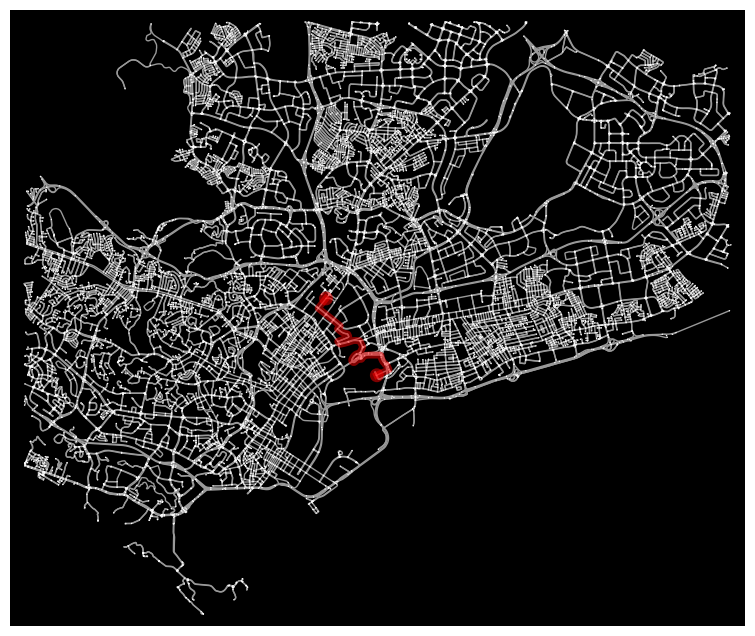

In [76]:
# calculate shortest path using dijkstra algorithm
path_lenght = nx.shortest_path(G, source=start_node, target=end_node, 
                                method='dijkstra', weight='lenght')     
print(path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red", 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))

[591879070, 634102724, 1931968386, 1931968401, 1931968421, 1931968404, 3633794265, 4604149152, 3633794709, 3633794930, 3979540669, 6989947839, 4581929502, 206401690, 3633794947, 5284714521, 5131578365, 5131312887, 3066270514, 4604554270, 3959880698, 3066270310, 5241830705, 5241830700, 4604543753, 246957101, 378608291, 246957098, 5166514999, 4740574112, 5243487086, 229576256, 377553457]


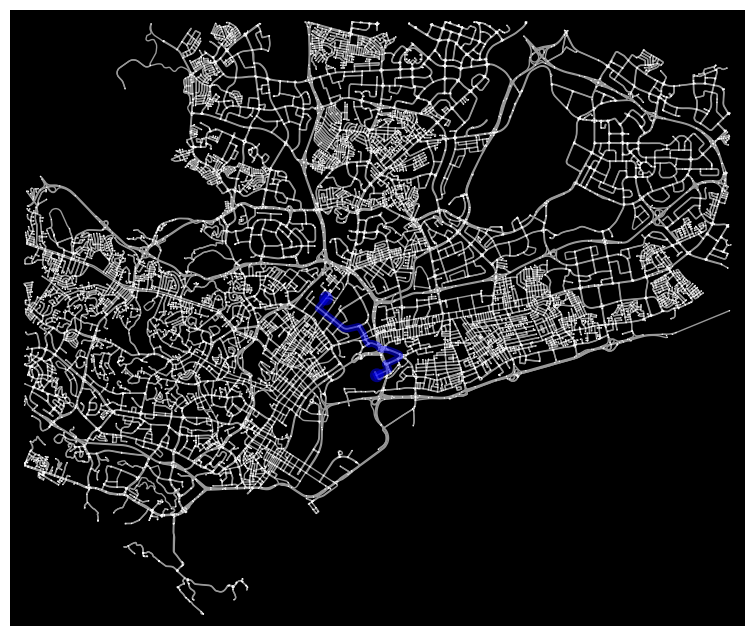

In [77]:
# calculate shortest path optimized for time
path_time = nx.shortest_path(G, source=start_node, target=end_node, 
                              method='dijkstra', weight='travel_time')   
print(path_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_time, route_color="blue", 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))

Red  route: 5.21 km | 6.24 min
Blue route: 4.36 km | 5.03 min


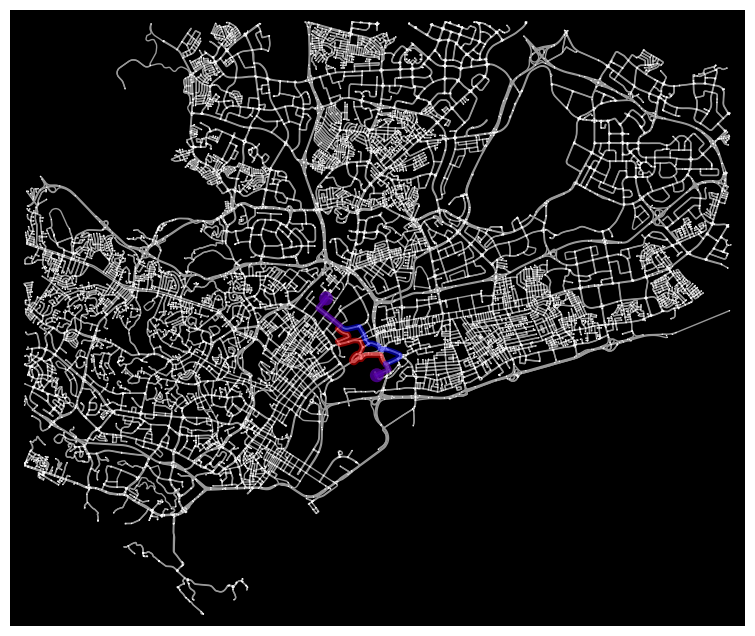

In [78]:
# We can compare the paths on the graph…

print('Red  route:',
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'length'))/1000, 2),
      'km |',
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'travel_time'))/60, 2),
      'min')

print('Blue route:',
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'length'))/1000, 2),
      'km |',
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'travel_time'))/60, 2),
      'min')

# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[path_lenght, path_time], 
                              route_colors=["red","blue"], 
                              route_linewidth=5, node_size=1, 
                              bgcolor='black', node_color="white", 
                              figsize=(16,8))

In [79]:
# plot on the map to compare both paths
# display data points as locations on a map using folium

map_ = plot_map(df, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=path_lenght, route_map=map_, 
                     color="red", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_, 
                     color="blue", weight=1)
map_

## 2 - Animation

### Single path

In [67]:
def df_animation_single_path(G, path):
    lst_start, lst_end = [],[]
    start_x, start_y = [],[]
    end_x, end_y = [],[]
    lst_length, lst_time = [],[]

    for a,b in zip(path[:-1], path[1:]):
        lst_start.append(a)
        lst_end.append(b)
        lst_length.append(round(G.edges[(a,b,0)]['length']))
        lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
        start_x.append(G.nodes[a]['x'])
        start_y.append(G.nodes[a]['y'])
        end_x.append(G.nodes[b]['x'])
        end_y.append(G.nodes[b]['y'])

    dfa = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                       columns=["start","end","start_x","start_y","end_x","end_y","length","travel_time"]
                     ).reset_index().rename(columns={"index":"id"})
    return dfa

In [68]:
print("nodes: from", start_node, "--> to", end_node)

dfa = df_animation_single_path(G, path_time)
dfa.head()

nodes: from 591879070 --> to 377553457


id       start         end     start_x   start_y       end_x     end_y   
0   0   591879070   634102724  103.875515  1.301287  103.878602  1.302723  \
1   1   634102724  1931968386  103.878602  1.302723  103.877995  1.303863   
2   2  1931968386  1931968401  103.877995  1.303863  103.877700  1.304138   
3   3  1931968401  1931968421  103.877700  1.304138  103.877778  1.304263   
4   4  1931968421  1931968404  103.877778  1.304263  103.878049  1.304280   

   length  travel_time  
0     379           27  
1     145           10  
2      54            4  
3      17            1  
4      32            2

In [69]:
def plot_animation(dfa, start_node, end_node):
    ## create start/end df
    df_start = dfa[dfa["start"] == start_node]
    df_end = dfa[dfa["end"] == end_node]
    
    ## create basic map
    fig = px.scatter_mapbox(data_frame=dfa, lon="start_x", lat="start_y", zoom=15, width=1000, height=800, 
                            animation_frame="id", mapbox_style="carto-positron")
    ## add driver
    fig.data[0].marker = {"size":12}
    ## add start point
    fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
    fig.data[1].marker = {"size":15, "color":"red"}
    ## add end point
    fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
    fig.data[2].marker = {"size":15, "color":"green"}
    ## add route
    fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])
    return fig

In [70]:
plot_animation(dfa, start_node, end_node)

### Multiple Path

In [59]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    dfm = pd.DataFrame()
    for path in lst_paths:
        lst_start, lst_end = [],[]
        start_x, start_y = [],[]
        end_x, end_y = [],[]
        lst_length, lst_time = [],[]

        for a,b in zip(path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                           columns=["start","end","start_x","start_y","end_x","end_y","length","travel_time"]
                          )
        dfm = pd.concat([dfm,tmp], ignore_index=(not parallel))

    dfm = dfm.reset_index().rename(columns={"index":"id"})
    return dfm

In [60]:
first_node, last_node = start_node, end_node
lst_paths = [path_time, path_lenght]
print(len(lst_paths), "paths,", sum(len(i) for i in lst_paths), "nodes:", first_node, "...", last_node)

dfm = df_animation_multiple_path(G, lst_paths, parallel=True)
dfm.tail()

2 paths, 62 nodes: 591879070 ... 377553457


id       start         end     start_x   start_y       end_x     end_y   
55  23   246957098  5166514999  103.864354  1.315369  103.862724  1.316673  \
56  24  5166514999  4740574112  103.862724  1.316673  103.862546  1.316818   
57  25  4740574112  5243487086  103.862546  1.316818  103.860582  1.318349   
58  26  5243487086   229576256  103.860582  1.318349  103.860638  1.318424   
59  27   229576256   377553457  103.860638  1.318424  103.862572  1.320838   

    length  travel_time  
55     232           17  
56      26            2  
57     277           20  
58      10            1  
59     344           21

In [61]:
plot_animation(dfm, first_node, last_node)

## 3 - Preprocessing

In [80]:
# calculate a route to visit all the locations
# steps: generate the distance matrix of shortest-path costs between all locations, construct an initial solution, and improve it by a sequence of iterations.

## get the node for each location
df["node"] = df[["y","x"]].apply(lambda x: 
                           ox.distance.nearest_nodes(G, x[1], x[0]), 
                        axis=1)
df = df.drop_duplicates("node", keep='first')
df.head()

id         y           x amenity                    name  base        node
0   0  1.301344  103.875762    taxi    Little India Station     1   591879070
1   1  1.298414  103.850258    taxi  Tanjong Katong Complex     0  5765341406
2   2  1.333340  103.740644    taxi      Paya Lebar Station     0   247640498
3   3  1.280234  103.848762    taxi        Aljunied Station     0  5817301660
4   4  1.299981  103.822485    taxi                  Blk 19     0  1819424625

In [81]:
# calculating the distance matrix between all the locations in our dataset

## distance length function
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, 
                                    method='dijkstra', 
                                    weight='travel_time')
    except:
        d = np.nan
    return d


## apply the function
distance_matrix = np.asarray([[f(a,b) for b in df["node"].tolist()] 
                               for a in df["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, 
                               columns=df["node"].values, 
                               index=df["node"].values)
distance_matrix.head()

591879070    5765341406   247640498    5817301660   1819424625    
591879070           0.0        293.5        774.7        355.2        528.5  \
5765341406        342.4          0.0        544.0        196.0        239.1   
247640498         813.7        566.9          0.0        748.7        493.8   
5817301660        382.2        202.0        683.2          0.0        290.5   
1819424625        593.2        310.9        483.9        324.6          0.0   

            10732589504  229313881    232119579    246491816    4675722405    
591879070         838.3        568.8        256.0        508.3        511.9  \
5765341406        566.2        525.3        103.8        218.9        623.8   
247640498         353.7        789.0        570.1        466.8        986.6   
5817301660        560.7        644.8        164.5        312.1        666.8   
1819424625        385.3        668.7        354.6        146.9        850.1   

            ...  3063313201   246800552    1363263508   1275666709    
591879070   ...          NaN        339.7        429.5        356.8  \
5765341406  ...          NaN         93.3        140.1         67.4   
247640498   ...          NaN        621.1        534.3        576.6   
5817301660  ...          NaN        135.8        260.0        187.1   
1819424625  ...          NaN        229.5        126.5        235.6   

            215281233    1363270467   1931861630   4745413065   1832696228    
591879070         838.3        443.5        305.0        369.1          NaN  \
5765341406        738.5        357.2        145.8        270.4          NaN   
247640498         805.7        654.4        698.5        551.7          NaN   
5817301660        848.7        463.0         30.6        368.1          NaN   
1819424625        792.4        445.4        295.8        350.5          NaN   

            6993992144   
591879070         342.5  
5765341406        161.1  
247640498         711.8  
5817301660         28.1  
1819424625        283.1  

[5 rows x 48 columns]

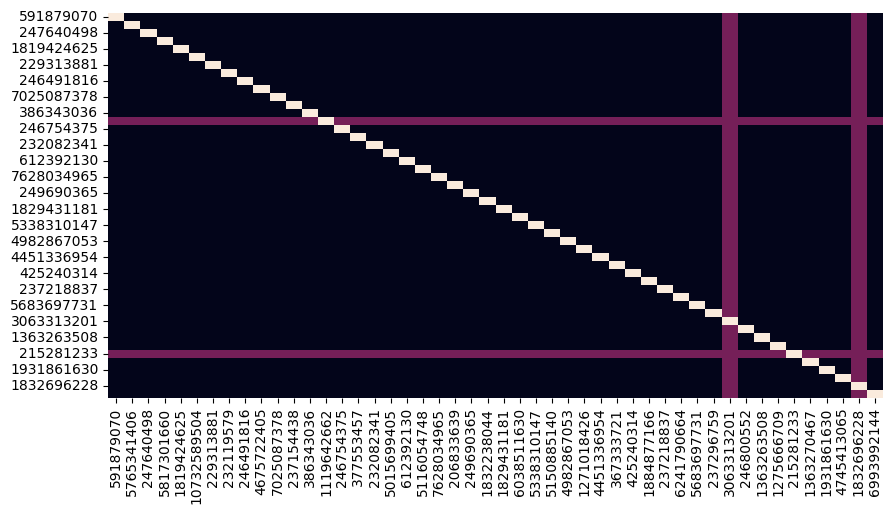

In [82]:
# heatmap of distance matrix

heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 
                       0.3 if pd.isnull(x) else  #nan -> purple
                      (0.7 if np.isinf(x) else   #inf -> orange
                      (0 if x!=0 else 1) ))      # 0  -> white  

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [83]:
# fillna with row average
# distance_matrix = distance_matrix.T.fillna(distance_matrix.mean(axis=1)).T

# fillna with overall average
distance_matrix = distance_matrix.fillna(distance_matrix.mean().mean())

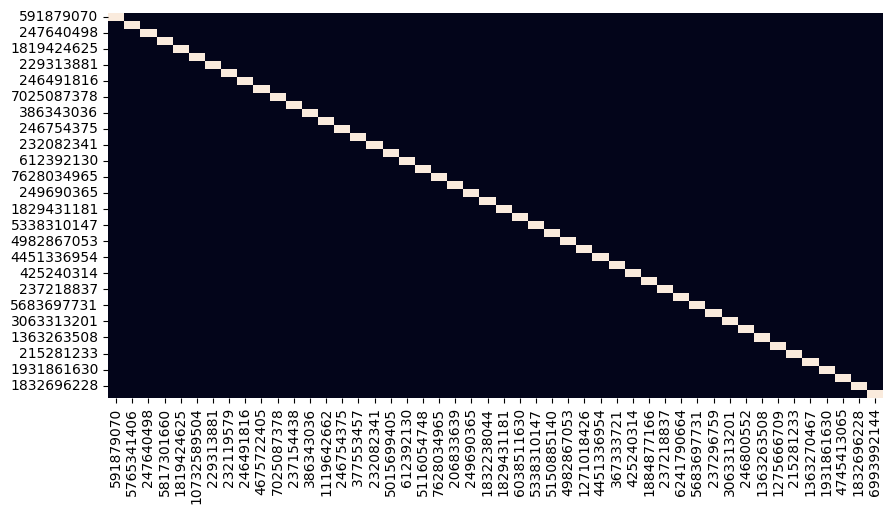

In [84]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 
                       0.3 if pd.isnull(x) else  #nan -> purple
                      (0.7 if np.isinf(x) else   #inf -> orange
                      (0 if x!=0 else 1) ))      # 0  -> white  

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

## Travelling Salesman Problem (Shortest Route)

In [85]:
## Business parameters
drivers = 1

In [101]:
lst_nodes = df['node'].tolist()
print("start:", start_node, "| tot locations to visit:", len(lst_nodes)-1, "| drivers:", drivers)

start: 591879070 | tot locations to visit: 47 | drivers: 3


In [102]:
len(distance_matrix.iloc[1])

48

In [103]:
## model
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance (cost)
def get_distance(from_index, to_index):
    #from_node = manager.IndexToNode(from_index)
    #to_node = manager.IndexToNode(to_index)
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

## set strategy to minimize cost (distance)
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

## solution
index = model.Start(0)
print('Route for driver:')
route_idx, route_distance = [], 0
while not model.IsEnd(index):
    route_idx.append( manager.IndexToNode(index) ) 
    previous_index = index
    index = solution.Value( model.NextVar(index) )
    ### update distance
    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance/1000,2)} km')
print(f'Nodes visited: {len(route_idx)}')

Route for driver:
[0]
Total distance: 0.0 km
Nodes visited: 1


## Vehicle Routing Problem

In [88]:
## Business parameters
drivers = 3
driver_capacities = [20,20,20]
demands = [0] + [1]*(len(lst_nodes)-1)
max_distance = 1000

In [89]:
print("start:", start_node, "| tot locations to visit:", len(lst_nodes)-1, "| drivers:", drivers)


start: 591879070 | tot locations to visit: 47 | drivers: 3


In [90]:
len(distance_matrix.iloc[1])

48

In [91]:
## model
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance (cost)
def get_distance(from_index, to_index):
    #from_node = manager.IndexToNode(from_index)
    #to_node = manager.IndexToNode(to_index)
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

## add capacity (costraint)
def get_demand(from_index):
    #from_node = manager.IndexToNode(from_index)
    return demands[from_index]

demand = model.RegisterUnaryTransitCallback(get_demand)
model.AddDimensionWithVehicleCapacity(demand, slack_max=0, 
                                      vehicle_capacities=driver_capacities, 
                                      fix_start_cumul_to_zero=True, 
                                      name='Capacity')

## add limited distance (costraint)
name = 'Distance'
model.AddDimension(distance, slack_max=0, capacity=max_distance, 
                   fix_start_cumul_to_zero=True, name=name)
distance_dimension = model.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

## set strategy to minimize cost (distance)
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

## solution
dic_routes_idx, total_distance, total_load = {}, 0, 0
for driver in range(drivers):
    print(f'Route for driver {driver}:')
    index = model.Start(driver)
    route_idx, route_distance, route_load = [], 0, 0
    while not model.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route_idx.append( manager.IndexToNode(index) )
        previous_index = index
        index = solution.Value( model.NextVar(index) )
        ### update distance
        try:
            route_distance += get_distance(previous_index, index)
        except:
            route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=driver)
        ### update load
        route_load += demands[node_index]
        
    route_idx.append( manager.IndexToNode(index) )
    print(route_idx)
    dic_routes_idx[driver] = route_idx
    print(f'distance: {round(route_distance/1000,2)} km')
    print(f'load: {round(route_load,2)}', "\n")
    total_distance += route_distance
    total_load += route_load
    
print(f'Total distance: {round(total_distance/1000,2)} km')
print(f'Total load: {total_load}')

Route for driver 0:
[0, 7, 6, 5, 4, 3, 2, 1, 0]
distance: 3.57 km
load: 7 

Route for driver 1:
[0, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 0]
distance: 10.92 km
load: 20 

Route for driver 2:
[0, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 0]
distance: 11.01 km
load: 20 

Total distance: 25.49 km
Total load: 47


In [92]:
dic_route = {}
for k,v in dic_routes_idx.items():
    print(f"Route for driver {k} (nodes):")
    dic_route[k] = [lst_nodes[i] for i in v]
    print(dic_route[k], "\n")

Route for driver 0 (nodes):
[591879070, 232119579, 229313881, 10732589504, 1819424625, 5817301660, 247640498, 5765341406, 591879070] 

Route for driver 1 (nodes):
[591879070, 5150885140, 5338310147, 6038511630, 1829431181, 1832238044, 249690365, 206833639, 7628034965, 5116054748, 612392130, 5015699405, 232082341, 377553457, 246754375, 1119642662, 386343036, 237154438, 7025087378, 4675722405, 246491816, 591879070] 

Route for driver 2 (nodes):
[591879070, 6993992144, 1832696228, 4745413065, 1931861630, 1363270467, 215281233, 1275666709, 1363263508, 246800552, 3063313201, 237296759, 5683697731, 6241790664, 237218837, 1884877166, 425240314, 367333721, 4451336954, 1271018426, 4982867053, 591879070] 



### Plot


In [94]:
# Get path between nodes
def get_path_between_nodes(lst_route):
    lst_paths = []
    for i in range(len(lst_route)):
        ## get node and next-node
        try:
            a,b = lst_route[i], lst_route[i+1]
        except:
            break
        ## get path
        try:
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

In [95]:
dic_paths = {k:get_path_between_nodes(v) for k,v in dic_route.items()}
len(dic_paths)

3

In [96]:
# plot on the map
map_ = plot_map(df, y="y", x="x", start=start, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

lst_colors = ["red","green","blue"]
for k,v in dic_paths.items():
    for path in v:
        ox.plot_route_folium(G, route=path, route_map=map_, color=lst_colors[k], weight=1)
map_

In [99]:
dfp = pd.DataFrame()
for driver,lst_paths in dic_paths.items():
    tmp = df_animation_multiple_path(G, lst_paths, parallel=False)
    dfp = pd.concat([dfp,tmp], axis=0)

first_node, last_node = lst_paths[0][0], lst_paths[-1][-1]
plot_animation(dfp, first_node, last_node)

ValueError: Value of 'lat' is not the name of a column in 'data_frame'. Expected one of ['id', 'y', 'x', 'amenity', 'name', 'base', 'node'] but received: start_y